In [1]:
from sksurv.nonparametric import kaplan_meier_estimator
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [2]:
# 사용할 패키지를 import합니다
import sys
print('python', sys.version)

import numpy as np
import pandas as pd
import matplotlib as mpl

import glob
import pickle
import matplotlib.pyplot as plt
plt.rc("font", family="Malgun Gothic") # window
plt.rc("axes", unicode_minus=False) # x,y축 (-)부호 표시

import seaborn as sns
from scipy.stats import hypergeom

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


In [17]:
## clinical
cln=pd.read_table('../data/TCGA_clinical_2023/TCGA-BRCA_clinical.csv', sep=',', index_col=1)[['days_to_death']]
cln=cln.dropna()
cln['days_to_death']=cln['days_to_death']/365
cln['event']=True

## expression
BRCA_exp=pickle.load(open("../mid_result/merged_data/BRCA.pickle", 'rb'))
BRCA_met_exp=BRCA_exp.loc[BRCA_exp['class']==1]
BRCA_met_exp
#BRCA_met_exp=BRCA_exp.copy()
## merged
merged_df=pd.merge(BRCA_met_exp, cln, how='inner', left_index=True, right_index=True)
merged_df

,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1,ZZZ3,hsa-mir-1253,hsa-mir-423,snoZ196,class
TCGA-3C-AALI,0.000000,0.0,0.262977,0.181146,0.727397,0.028047,5.776889,0.417651,0.066775,0.0,...,0.0,2.221965,6.178362,0.0,2.394029,1.799933,0.0,0.0,0.267867,1
TCGA-3C-AALJ,0.062481,0.0,0.000000,0.173329,0.662246,0.040550,5.987103,0.284267,0.052538,0.0,...,0.0,2.199506,6.118358,0.0,2.086615,2.202575,0.0,0.0,0.504402,1
TCGA-4H-AAAK,0.072996,0.0,0.000000,0.206432,0.689244,0.015174,6.385138,0.563828,0.090556,0.0,...,0.0,2.604653,5.947094,0.0,1.890794,2.820608,0.0,0.0,0.000000,1
TCGA-A1-A0SG,0.142912,0.0,0.000000,0.110922,0.689850,0.000000,6.671130,0.374137,0.090539,0.0,...,0.0,2.539676,5.398397,0.0,2.798767,2.366549,0.0,0.0,0.000000,1
TCGA-A1-A0SI,0.051809,0.0,0.012770,0.110147,0.604240,0.007840,6.301181,0.489616,0.152111,0.0,...,0.0,2.864584,6.019661,0.0,2.120740,2.800810,0.0,0.0,0.455913,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-UU-A93S,0.000000,0.0,0.000000,0.391912,0.615234,0.000000,4.521005,0.110479,0.063634,0.0,...,0.0,2.420773,5.853344,0.0,1.794056,2.125242,0.0,0.0,0.666879,1
TCGA-V7-A7HQ,0.118835,0.0,0.000000,0.079229,0.320901,0.000000,4.876982,0.170127,0.352551,0.0,...,0.0,1.898363,5.664242,0.0,1.927646,2.030582,0.0,0.0,0.000000,1
TCGA-WT-AB41,0.000000,0.0,0.000000,0.068493,0.114900,0.000000,5.305957,0.342910,0.060095,0.0,...,0.0,1.278673,5.875246,0.0,1.535464,1.790688,0.0,0.0,0.000000,1
TCGA-XX-A899,0.017357,0.0,0.000000,0.092786,0.497109,0.007835,7.495361,0.440644,0.027786,0.0,...,0.0,2.302585,6.442212,0.0,2.797599,2.407363,0.0,0.0,0.742535,1


,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,ZYX,ZYXP1,ZZEF1,ZZZ3,hsa-mir-1253,hsa-mir-423,snoZ196,class,days_to_death,event
TCGA-A2-A04P,0.024796,0.026156,0.011998,0.035949,0.186127,0.014685,5.633612,0.113626,3.750538,0.055283,...,5.484014,0.0,1.730213,2.477839,0.0,0.0,0.526757,1,1.501370,True
TCGA-A2-A0CS,0.140466,0.000000,0.000000,0.220555,0.800722,0.000000,4.862240,0.472704,0.116271,0.000000,...,5.853344,0.0,2.338875,2.139058,0.0,0.0,0.000000,1,6.432877,True
TCGA-A2-A0EW,0.037371,0.000000,0.000000,0.090556,0.753756,0.007304,7.650138,0.776894,0.073814,0.000000,...,5.592485,0.0,2.966874,3.329055,0.0,0.0,0.000000,1,5.161644,True
TCGA-A2-A0SV,0.061079,0.000000,0.032423,0.076138,0.494661,0.012338,6.413282,0.527080,0.336642,0.176101,...,5.837442,0.0,1.799665,2.243269,0.0,0.0,0.650173,1,2.260274,True
TCGA-A2-A0SW,0.000000,0.000000,0.000000,0.002350,0.181037,0.005843,6.087495,0.205690,0.374671,0.000000,...,5.657977,0.0,1.914807,2.601197,0.0,0.0,0.846312,1,3.739726,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EW-A1P8,0.000000,0.000000,0.000000,0.094772,0.493179,0.015003,5.891568,0.662529,1.895242,0.000000,...,6.330279,0.0,2.112083,3.129803,0.0,0.0,0.335740,1,0.654795,True
TCGA-GM-A2DA,0.000000,0.000000,0.000000,0.044751,0.375906,0.016996,6.371036,0.346181,0.049002,0.000000,...,5.706643,0.0,1.938039,2.624698,0.0,0.0,0.459235,1,18.063014,True
TCGA-HN-A2OB,0.021170,0.000000,0.011931,0.048607,0.713592,0.000000,7.344401,0.762268,0.103981,0.000000,...,6.368263,0.0,2.347044,2.746777,0.0,0.0,0.525631,1,5.205479,True
TCGA-PE-A5DC,0.000000,0.000000,0.014974,0.074946,0.560193,0.008664,6.598788,0.715010,0.132042,0.000000,...,5.882376,0.0,1.613929,2.792890,0.0,0.0,0.450366,1,3.917808,True


In [5]:
## MGs
FS_df=pickle.load(open("../main_result/sig_res/BRCA.pickle", 'rb'))
FS_df

,FS,epval
ZNF676,0.123038,0.0
FAM163B,0.093631,0.0
LDOC1,0.087836,0.0
FAM78B,0.087489,0.0
IRF1,0.086791,0.0
...,...,...
EEF1AKMT4,0.000000,1.0
FAM160B1,0.000000,1.0
GSC2,0.000000,1.0
NKG7,0.000000,1.0


In [7]:
pval_sr=pd.Series()
for g1 in FS_df.index[:202]:
    md=merged_df[g1].median()
    df_hig=merged_df.loc[merged_df[g1]>md]
    df_low=merged_df.loc[merged_df[g1]<=md]
    pval=logrank_test(df_hig["days_to_death"], df_low["days_to_death"], df_hig["event"], df_low["event"]).p_value
    pval_sr.loc[g1]=pval

C:\Users\jmjun\AppData\Local\Temp\ipykernel_24064\652912417.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval_sr=pd.Series()


In [8]:
pval_sr.sort_values().head(20)

SPPL2C     0.000144
KRT23      0.007411
RGS7       0.008201
WT1        0.018999
ZNF676     0.025646
NUTM2E     0.033720
NEK10      0.036148
SRD5A3     0.042672
CHRNA5     0.053042
HR         0.054477
IBSP       0.055292
LAMP5      0.057466
EGLN2      0.057981
PAX5       0.064086
FAM163B    0.070317
KLLN       0.071487
KRT9       0.074461
NAP1L3     0.078983
SRP14      0.083308
MMP9       0.090254
dtype: float64

('SPPL2C', 48, 48)

('KRT23', 48, 48)

('RGS7', 48, 48)

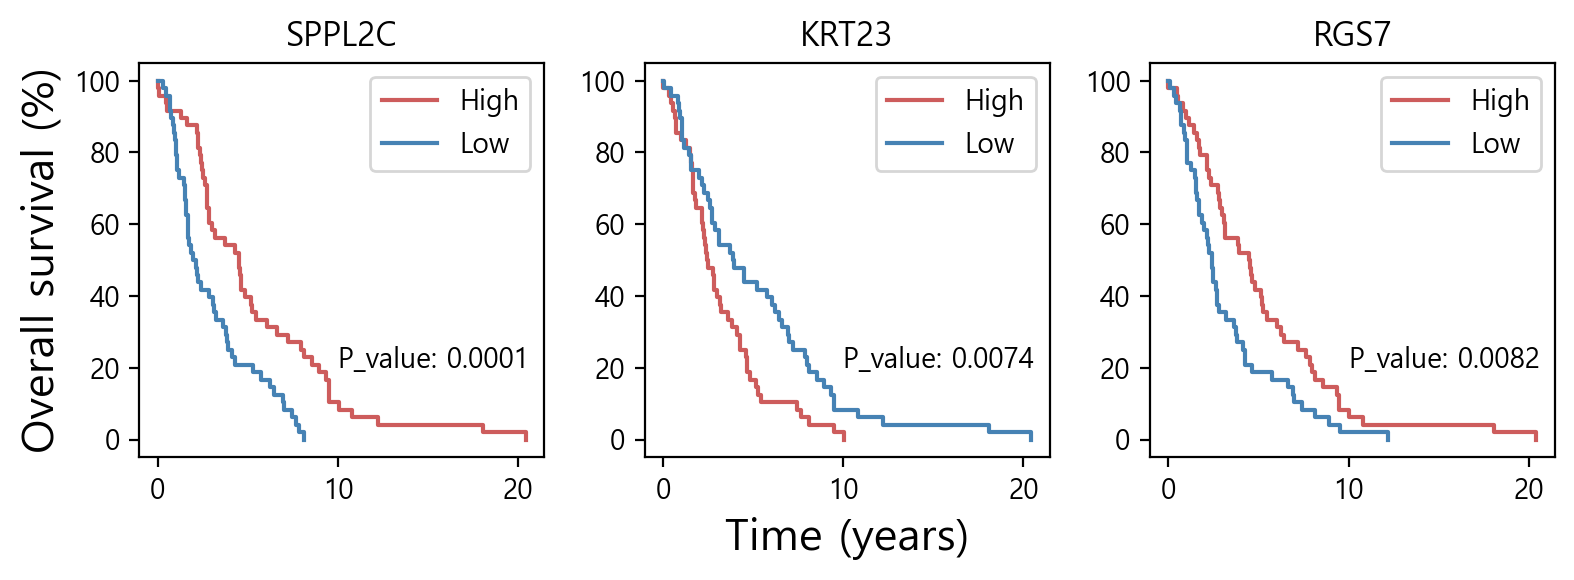

In [22]:
def draw_KME1(df1,ax, label, color):
    kmf = KaplanMeierFitter()
    kmf.fit(df1['days_to_death'], df1['event'], label=label)
    ax_kmf = kmf.plot(ax=ax, ci_show=False, c=color)

fig=plt.figure(figsize=(8,3), dpi=200)
axs=fig.subplots(1,3).flatten()
    
for g1, ax in zip(['SPPL2C','KRT23','RGS7'], axs):
    md=merged_df[g1].median()
    df_hig=merged_df.loc[merged_df[g1]>md]
    draw_KME1(df_hig,ax,'High', 'indianred')
    df_low=merged_df.loc[merged_df[g1]<=md]
    draw_KME1(df_low,ax,'Low','steelblue')
    g1,len(df_hig), len(df_low)
    pval=logrank_test(df_hig["days_to_death"], df_low["days_to_death"], df_hig["event"], df_low["event"]).p_value
    
    _=ax.set_title(g1)
    _=ax.set_xlabel('')
    
    _=ax.set_yticks(np.linspace(0,1.0,6))
    _=ax.set_yticklabels((np.linspace(0,1.0,6)*100).astype(int))
    
    _=ax.text(10, 0.2, 'P_value: {:.4f}'.format(pval), fontsize=10)
    
_=axs[1].set_xlabel('Time (years)', fontsize=16)
_=axs[0].set_ylabel('Overall survival (%)', fontsize=16)

fig.tight_layout()

('ZNF676', 48, 48)

('FAM163B', 48, 48)

('LDOC1', 48, 48)

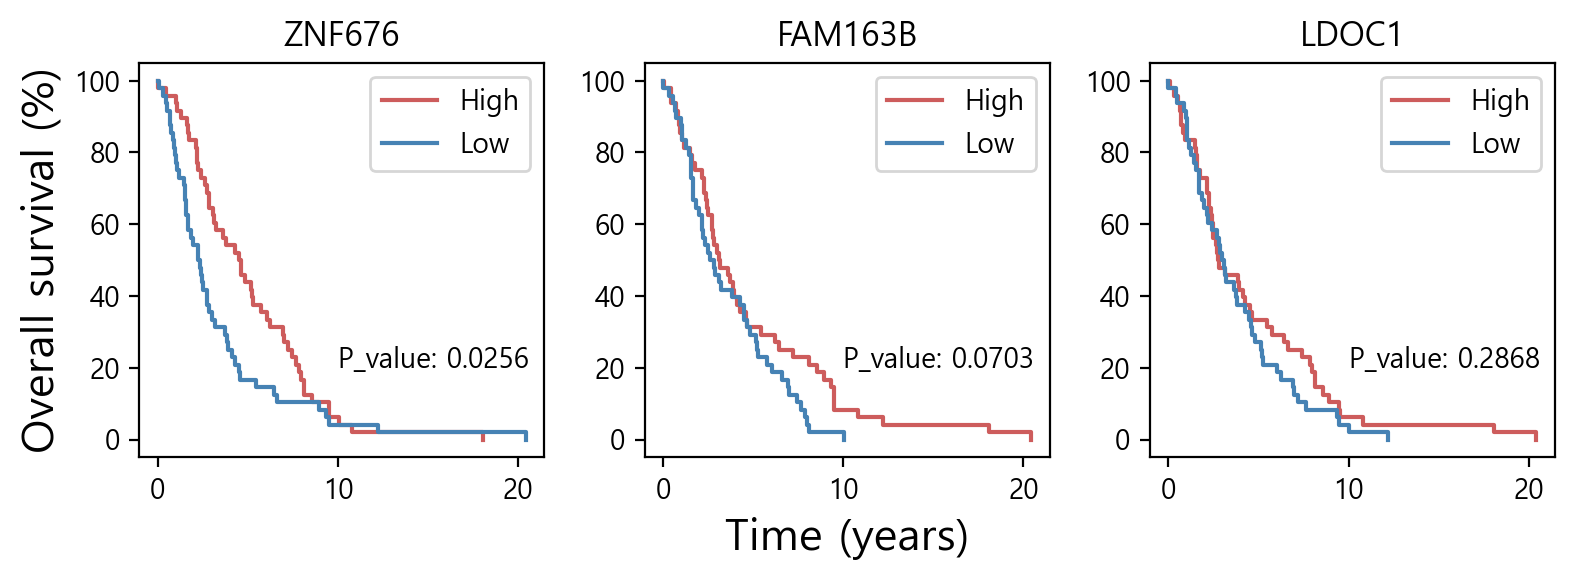

In [21]:
def draw_KME1(df1,ax, label, color):
    kmf = KaplanMeierFitter()
    kmf.fit(df1['days_to_death'], df1['event'], label=label)
    ax_kmf = kmf.plot(ax=ax, ci_show=False, c=color)

fig=plt.figure(figsize=(8,3), dpi=200)
axs=fig.subplots(1,3).flatten()
    
for g1, ax in zip(['ZNF676','FAM163B','LDOC1'], axs):
    md=merged_df[g1].median()
    df_hig=merged_df.loc[merged_df[g1]>md]
    draw_KME1(df_hig,ax,'High', 'indianred')
    df_low=merged_df.loc[merged_df[g1]<=md]
    draw_KME1(df_low,ax,'Low','steelblue')
    g1,len(df_hig), len(df_low)
    pval=logrank_test(df_hig["days_to_death"], df_low["days_to_death"], df_hig["event"], df_low["event"]).p_value
    
    _=ax.set_title(g1)
    _=ax.set_xlabel('')
    
    _=ax.set_yticks(np.linspace(0,1.0,6))
    _=ax.set_yticklabels((np.linspace(0,1.0,6)*100).astype(int))
    
    _=ax.text(10, 0.2, 'P_value: {:.4f}'.format(pval), fontsize=10)
    
_=axs[1].set_xlabel('Time (years)', fontsize=16)
_=axs[0].set_ylabel('Overall survival (%)', fontsize=16)

fig.tight_layout()